# Домашнее задание

### Чтение данных

In [41]:
import pandas as pd
import numpy as np


air_reserve = pd.read_csv("air_reserve.csv")
hpg_reserve = pd.read_csv("hpg_reserve.csv")
air_store_info = pd.read_csv("air_store_info.csv")
hpg_store_info = pd.read_csv("hpg_store_info.csv")
store_id_relation = pd.read_csv("store_id_relation.csv")
air_visit_data = pd.read_csv("air_visit_data.csv")
date_info = pd.read_csv("date_info.csv")
sample_submission = pd.read_csv('sample_submission.csv')


data_dict = {
    "air_reserve": air_reserve,
    "hpg_reserve": hpg_reserve,
    "air_store_info": air_store_info,
    "hpg_store_info": hpg_store_info,
    "store_id_relation": store_id_relation,
    "air_visit_data": air_visit_data,
    "date_info": date_info,
    "sample_submission": sample_submission,
}

for name, df in data_dict.items():
    print(f'Таблица {name.upper()}')
    print(df.head(20))

Таблица AIR_RESERVE
            air_store_id       visit_datetime     reserve_datetime  \
0   air_877f79706adbfb06  2016-01-01 19:00:00  2016-01-01 16:00:00   
1   air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
2   air_db4b38ebe7a7ceff  2016-01-01 19:00:00  2016-01-01 19:00:00   
3   air_877f79706adbfb06  2016-01-01 20:00:00  2016-01-01 16:00:00   
4   air_db80363d35f10926  2016-01-01 20:00:00  2016-01-01 01:00:00   
5   air_db80363d35f10926  2016-01-02 01:00:00  2016-01-01 16:00:00   
6   air_db80363d35f10926  2016-01-02 01:00:00  2016-01-01 15:00:00   
7   air_3bb99a1fe0583897  2016-01-02 16:00:00  2016-01-02 14:00:00   
8   air_3bb99a1fe0583897  2016-01-02 16:00:00  2016-01-01 20:00:00   
9   air_2b8b29ddfd35018e  2016-01-02 17:00:00  2016-01-02 17:00:00   
10  air_6b15edd1b4fbb96a  2016-01-02 17:00:00  2016-01-01 22:00:00   
11  air_6b15edd1b4fbb96a  2016-01-02 17:00:00  2016-01-01 12:00:00   
12  air_6b15edd1b4fbb96a  2016-01-02 17:00:00  2016-01-02 16:00:00   


### Создание датасета для прогнозирования

#### Таблица с ключевой переменной visitors

In [42]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])

air_visit_data = air_visit_data.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
) # цель = добавить holiday_flg
air_visit_data = air_visit_data.drop(columns=['calendar_date']) # уже есть visit_date

air_visit_data['month'] = air_visit_data['visit_date'].dt.month

air_visit_data = air_visit_data.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
) # цель = добавить air_genre_name, air_area_name, latitude, longitude



"""
Поработаем с air_reserve
"""

air_reserve = air_reserve.drop(columns=['reserve_datetime'])

air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date

# Суммируем визиторс по брони для каждой даты каждого ресторана
air_reserve = air_reserve.groupby(['air_store_id', 'visit_datetime'], as_index=False, sort=False)['reserve_visitors'].sum()

air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])

"""
Закончили работать с air_reserve
"""



air_visit_data = air_visit_data.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']], left_on=['air_store_id', 'visit_date'], right_on=['air_store_id', 'visit_datetime'], how='left'
)
air_visit_data = air_visit_data.drop(columns=['visit_datetime'])

# В некоторой части ресторанов отсутствует информация количества визиторс по брони. Заполним NaN нулями
air_visit_data['reserve_visitors'] = air_visit_data['reserve_visitors'].fillna(0)

air_visit_data = air_visit_data.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)
air_visit_data['hpg_store_id'] = air_visit_data['hpg_store_id'].fillna('unknown')


air_visit_data.info()
air_visit_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      252108 non-null  object        
 1   visit_date        252108 non-null  datetime64[ns]
 2   visitors          252108 non-null  int64         
 3   day_of_week       252108 non-null  object        
 4   holiday_flg       252108 non-null  int64         
 5   month             252108 non-null  int32         
 6   air_genre_name    252108 non-null  object        
 7   air_area_name     252108 non-null  object        
 8   latitude          252108 non-null  float64       
 9   longitude         252108 non-null  float64       
 10  reserve_visitors  252108 non-null  float64       
 11  hpg_store_id      252108 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(5)
memory usage: 22.1+ MB


,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown


#### Таблица с тестовыми данными (нулевые значения visitors)

In [43]:
# Разделим на idшники и будущие даты посещений
sample_submission['air_store_id'] = sample_submission['id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = sample_submission['id'].apply(lambda x: x.split('_')[-1])

sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])

sample_submission = sample_submission.drop(columns=['id'])

# добавим визиторс в конец, для аналогичности наглядной структуры
sample_submission['visitors'] = sample_submission.pop('visitors')

sample_submission = sample_submission.merge(
    date_info, left_on='visit_date', right_on='calendar_date', how='left'
)
sample_submission = sample_submission.drop(columns=['calendar_date'])

sample_submission['month'] = sample_submission['visit_date'].dt.month

sample_submission = sample_submission.merge(
    air_store_info[['air_store_id', 'air_genre_name', 'air_area_name', 'latitude', 'longitude']], on='air_store_id', how='left'
)

sample_submission = sample_submission.merge(
    air_reserve[['air_store_id', 'visit_datetime', 'reserve_visitors']], 
    left_on=['air_store_id', 'visit_date'], 
    right_on=['air_store_id', 'visit_datetime'], 
    how='left'
)
sample_submission = sample_submission.drop(columns=['visit_datetime'])

# В некоторой части ресторанов отсутствует информация количества визиторс по брони. Заполним NaN нулями
sample_submission['reserve_visitors'] = sample_submission['reserve_visitors'].fillna(0)

sample_submission = sample_submission.merge(
    store_id_relation[['air_store_id', 'hpg_store_id']], on='air_store_id', how='left'
)
sample_submission['hpg_store_id'] = sample_submission['hpg_store_id'].fillna('unknown')

sample_submission.info()
sample_submission

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      32019 non-null  object        
 1   visit_date        32019 non-null  datetime64[ns]
 2   visitors          32019 non-null  int64         
 3   day_of_week       32019 non-null  object        
 4   holiday_flg       32019 non-null  int64         
 5   month             32019 non-null  int32         
 6   air_genre_name    32019 non-null  object        
 7   air_area_name     32019 non-null  object        
 8   latitude          32019 non-null  float64       
 9   longitude         32019 non-null  float64       
 10  reserve_visitors  32019 non-null  float64       
 11  hpg_store_id      32019 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(5)
memory usage: 2.8+ MB


,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_00a91d42b08b08d9,2017-04-23,0,Sunday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
1,air_00a91d42b08b08d9,2017-04-24,0,Monday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
2,air_00a91d42b08b08d9,2017-04-25,0,Tuesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
3,air_00a91d42b08b08d9,2017-04-26,0,Wednesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
4,air_00a91d42b08b08d9,2017-04-27,0,Thursday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32015,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32016,air_fff68b929994bfbd,2017-05-29,0,Monday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32017,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown


### Исключение аномалий по каждому ресторану и в целом. Межквартильные расстояния

Количество глобальных аномальных точек: 6925
Новый размер массива данных: 240023
Квартиль 25% в целом: 9.0
Квартиль 75% в целом: 28.0
Межквартиль в целом: 19.0
Границы отклонения в целом: [0, 56.5]


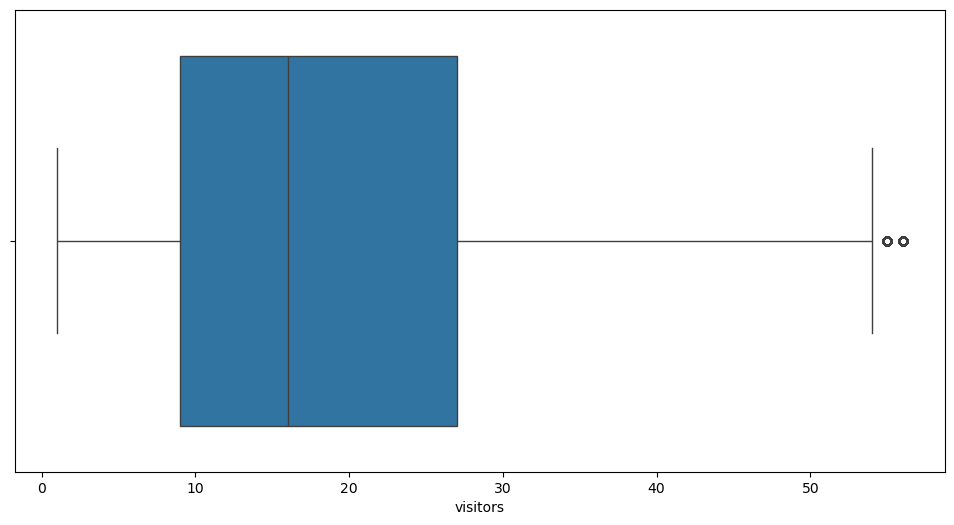

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,1,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
240018,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240019,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240020,air_24e8414b9b07decb,2017-04-20,7,Thursday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown
240021,air_24e8414b9b07decb,2017-04-21,8,Friday,0,4,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,0.0,unknown


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cleaned_air_visit_data = pd.DataFrame()

# Исключение аномалий по каждому ресторану
for store_id, group in air_visit_data.groupby('air_store_id', as_index=False, sort=False):

    Q1 = group['visitors'].quantile(0.25)
    Q3 = group['visitors'].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = max(0, Q1 - 1.5 * IQR)
    upper_bound = Q3 + 1.5 * IQR
    
    cleaned_group = group[(group['visitors'] >= lower_bound) & (group['visitors'] <= upper_bound)]
    cleaned_air_visit_data = pd.concat([cleaned_air_visit_data, cleaned_group])

# Исключение аномалий в целом
Q1_global = cleaned_air_visit_data['visitors'].quantile(0.25)
Q3_global = cleaned_air_visit_data['visitors'].quantile(0.75)
IQR_global = Q3_global - Q1_global

lower_bound_global = max(0, Q1_global - 1.5 * IQR_global)
upper_bound_global = Q3_global + 1.5 * IQR_global

anomalies = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] < lower_bound_global) | 
    (cleaned_air_visit_data['visitors'] > upper_bound_global)
]

cleaned_air_visit_data = cleaned_air_visit_data[
    (cleaned_air_visit_data['visitors'] >= lower_bound_global) & 
    (cleaned_air_visit_data['visitors'] <= upper_bound_global)
]

print(f'Количество глобальных аномальных точек: {len(anomalies)}')
print(f'Новый размер массива данных: {len(cleaned_air_visit_data)}')
print(f'Квартиль 25% в целом: {Q1_global}')
print(f'Квартиль 75% в целом: {Q3_global}')
print(f'Межквартиль в целом: {IQR_global}')
print(f'Границы отклонения в целом: [{lower_bound_global}, {upper_bound_global}]')

plt.figure(figsize=(12, 6))
sns.boxplot(x=cleaned_air_visit_data['visitors'])
plt.show()

cleaned_air_visit_data.reset_index(drop=True, inplace=True)
cleaned_air_visit_data

### Анализ данных с графиками

#### Распределение посетителей

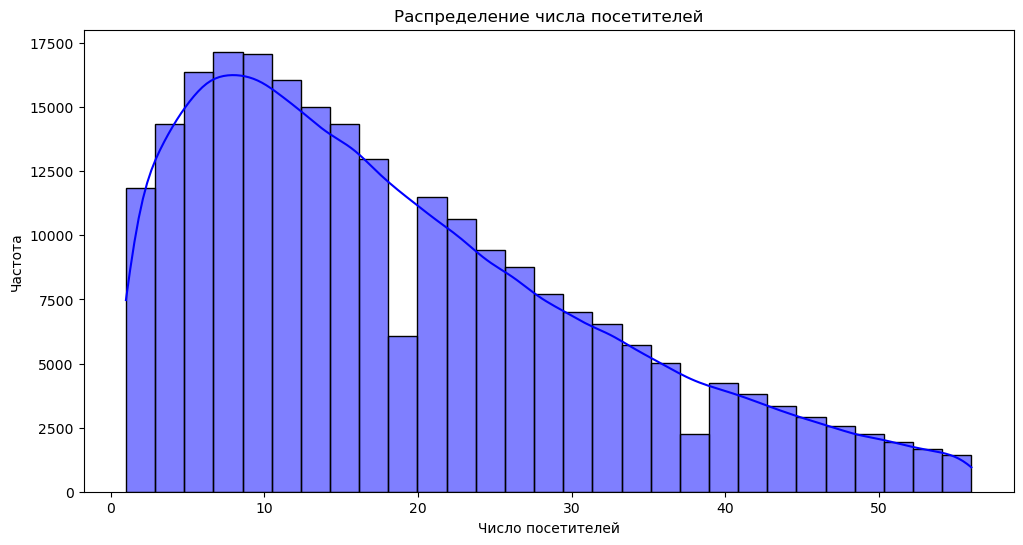

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(cleaned_air_visit_data['visitors'], bins=29, kde=True, color='blue')

plt.title('Распределение числа посетителей')
plt.xlabel('Число посетителей')
plt.ylabel('Частота')
plt.show()

#### Среднее распределение поситителей по дням недели

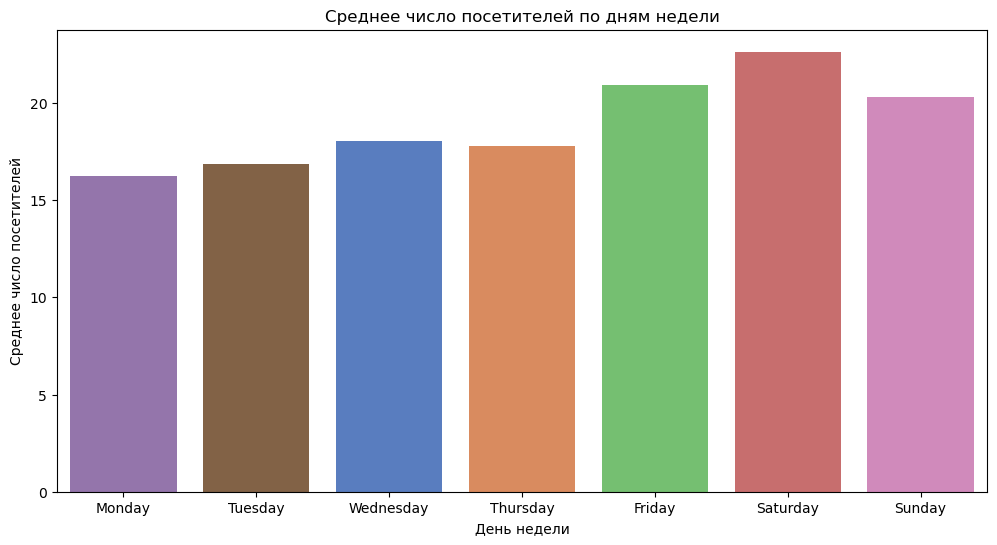

In [46]:
visitors_by_day = cleaned_air_visit_data.groupby('day_of_week', sort=False)['visitors'].mean()

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='visitors', data=visitors_by_day.reset_index(), order=days, palette='muted', hue='day_of_week')
plt.title('Среднее число посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Среднее число посетителей')
plt.show()


#### Распределение посетителей по дням недели

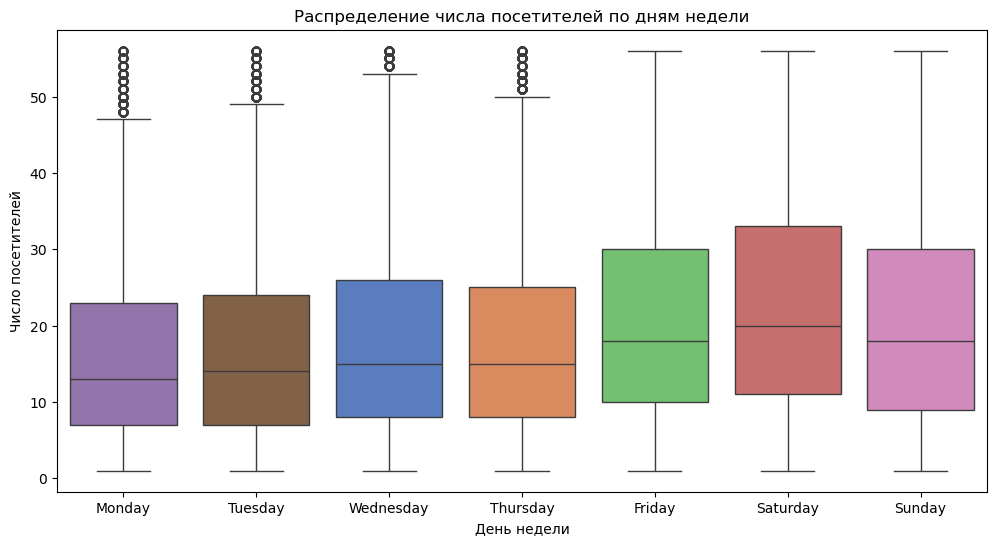

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y='visitors', data=cleaned_air_visit_data, order=days, palette='muted', hue='day_of_week')
plt.title('Распределение числа посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Число посетителей')
plt.show()


#### Среднее число посетителей по дням

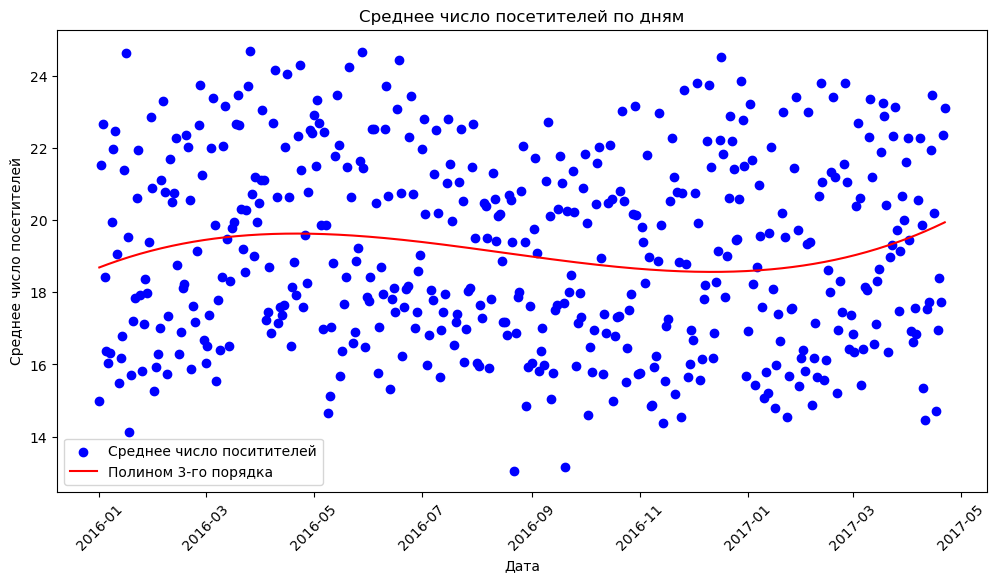

In [48]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

avg_visitors = cleaned_air_visit_data.groupby('visit_date')['visitors'].mean().reset_index()

avg_X = (avg_visitors['visit_date'] - avg_visitors['visit_date'].min()).dt.days.values.reshape(-1, 1)
avg_y = avg_visitors['visitors']

polynom = PolynomialFeatures(degree=3)
polynom_X = polynom.fit_transform(avg_X)

model = LinearRegression()
model.fit(polynom_X, avg_y)

polynom_pred_y = model.predict(polynom_X)

plt.figure(figsize=(12, 6))
plt.scatter(avg_visitors['visit_date'], avg_visitors['visitors'], color='blue', label='Среднее число поситителей')
plt.plot(avg_visitors['visit_date'], polynom_pred_y, color='red', label='Полином 3-го порядка')

plt.title('Среднее число посетителей по дням')
plt.xlabel('Дата')
plt.ylabel('Среднее число посетителей')
plt.legend()
plt.xticks(rotation=45)
plt.show()


#### Среднее количество по месяцам

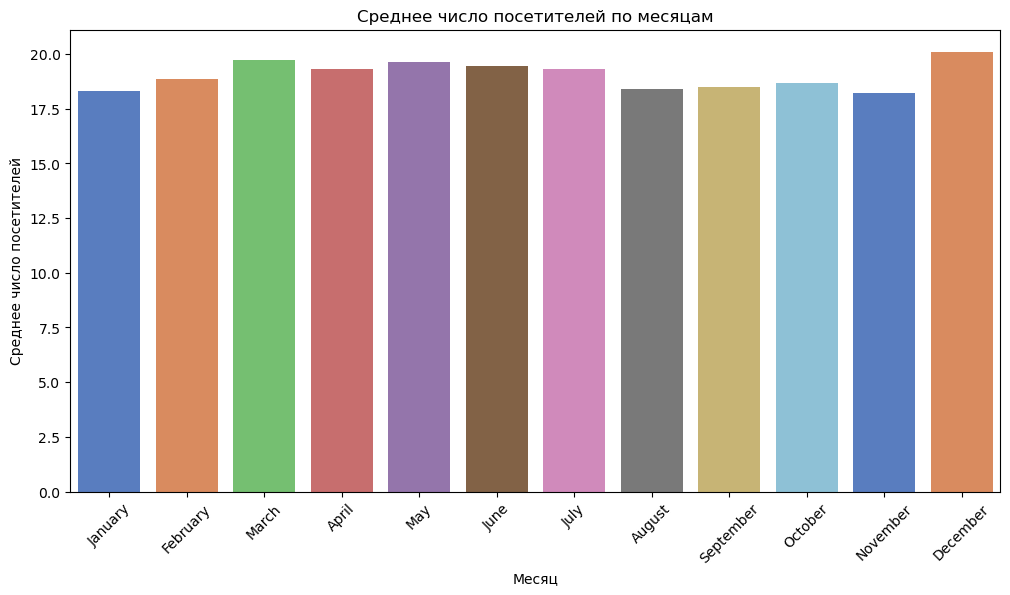

In [49]:
cleaned_air_visit_data['month'] = cleaned_air_visit_data['visit_date'].dt.month

visitors_by_month = cleaned_air_visit_data.groupby('month', sort=False)['visitors'].mean()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='visitors', data=visitors_by_month.reset_index(), order=range(1, 13), palette='muted', hue='month')
plt.title('Среднее число посетителей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее число посетителей')
plt.xticks(ticks=range(12), labels=months, rotation=45)
plt.legend([], [], frameon=False)
plt.show()


### Выбор признаков и их кодирование

In [50]:
cleaned_air_visit_data.info()
sample_submission.info()
#cleaned_air_visit_data
sample_submission

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240023 entries, 0 to 240022
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      240023 non-null  object        
 1   visit_date        240023 non-null  datetime64[ns]
 2   visitors          240023 non-null  int64         
 3   day_of_week       240023 non-null  object        
 4   holiday_flg       240023 non-null  int64         
 5   month             240023 non-null  int32         
 6   air_genre_name    240023 non-null  object        
 7   air_area_name     240023 non-null  object        
 8   latitude          240023 non-null  float64       
 9   longitude         240023 non-null  float64       
 10  reserve_visitors  240023 non-null  float64       
 11  hpg_store_id      240023 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(5)
memory usage: 21.1+ MB
<class 'pandas.core.frame.D

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,month,air_genre_name,air_area_name,latitude,longitude,reserve_visitors,hpg_store_id
0,air_00a91d42b08b08d9,2017-04-23,0,Sunday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
1,air_00a91d42b08b08d9,2017-04-24,0,Monday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
2,air_00a91d42b08b08d9,2017-04-25,0,Tuesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
3,air_00a91d42b08b08d9,2017-04-26,0,Wednesday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
4,air_00a91d42b08b08d9,2017-04-27,0,Thursday,0,4,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0.0,hpg_fbe603376b5980fc
...,...,...,...,...,...,...,...,...,...,...,...,...
32014,air_fff68b929994bfbd,2017-05-27,0,Saturday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32015,air_fff68b929994bfbd,2017-05-28,0,Sunday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32016,air_fff68b929994bfbd,2017-05-29,0,Monday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown
32017,air_fff68b929994bfbd,2017-05-30,0,Tuesday,0,5,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,0.0,unknown


In [51]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


# Обучающая выборка
cleaned_air_visit_data_encoded = cleaned_air_visit_data.copy().reset_index(drop=True)
cleaned_air_visit_data_merge = cleaned_air_visit_data.copy().reset_index(drop=True) # чтобы в конце NaN и NaT не вышло, индексы не состыкуются

selected_features = cleaned_air_visit_data[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(selected_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(selected_features.columns))

cleaned_air_visit_data_encoded = pd.concat([cleaned_air_visit_data_merge, encoded_df], axis=1)
cleaned_air_visit_data_encoded = cleaned_air_visit_data_encoded.drop(columns=['air_store_id', 'visit_date', 
                                                                              'visitors', 'day_of_week', 
                                                                              'holiday_flg', 'month',
                                                                              'air_genre_name', 'air_area_name',
                                                                              'hpg_store_id'])

# Тестовая выборка
sample_submission_encoded = sample_submission.copy()

selected_features_test = sample_submission_encoded[['day_of_week', 'holiday_flg', 'month', 'air_genre_name', 'air_area_name', 'hpg_store_id']]

encoded_features_test = encoder.fit_transform(selected_features_test)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoder.get_feature_names_out(selected_features_test.columns))

sample_submission_encoded = pd.concat([sample_submission, encoded_df_test], axis=1)
sample_submission_encoded = sample_submission_encoded.drop(columns=['air_store_id', 'visit_date', 
                                                                    'visitors', 'day_of_week', 
                                                                    'holiday_flg', 'month',
                                                                    'air_genre_name', 'air_area_name',
                                                                    'hpg_store_id'])

# в тестовой выборке два месяца, в обучающей - 12. Дополним столбцы и заполним нулями
missing_month_columns = [f'month_{i}' for i in range(1, 13) if f'month_{i}' not in sample_submission_encoded.columns]
for col in missing_month_columns:
    sample_submission_encoded[col] = 0.0

# делаем одинаковый порядок столбцов
sample_submission_encoded = sample_submission_encoded[cleaned_air_visit_data_encoded.columns]

cleaned_air_visit_data_encoded.info()
sample_submission_encoded.info()
sample_submission_encoded
#cleaned_air_visit_data_encoded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240023 entries, 0 to 240022
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 521.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32019 entries, 0 to 32018
Columns: 285 entries, latitude to hpg_store_id_unknown
dtypes: float64(285)
memory usage: 69.6 MB


,latitude,longitude,reserve_visitors,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,holiday_flg_1,...,hpg_store_id_hpg_ee8cad9cd96718da,hpg_store_id_hpg_ef517ab154f66a8e,hpg_store_id_hpg_f07ec7b288165b27,hpg_store_id_hpg_f39996d4f0ebcb64,hpg_store_id_hpg_f76ad2d2d0134bdd,hpg_store_id_hpg_f83413cde79ac5e7,hpg_store_id_hpg_fa4eeada9ad7b59f,hpg_store_id_hpg_fbe603376b5980fc,hpg_store_id_hpg_fc892fe8d342a787,hpg_store_id_unknown
0,35.694003,139.753595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,35.694003,139.753595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,35.694003,139.753595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,35.694003,139.753595,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,35.694003,139.753595,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32014,35.708146,139.666288,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32015,35.708146,139.666288,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32016,35.708146,139.666288,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32017,35.708146,139.666288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Установка библиотек

In [52]:
#import sys
#!{sys.executable} -m pip install xgboost

### Обучение моделей и подбор гиперпараметров

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb


# Признаки и целевая величина
X_train = cleaned_air_visit_data_encoded
y_train = cleaned_air_visit_data['visitors']

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

gyper_parameters= {
    "Linear Regression": {},
    "XGBoost": {
        'n_estimators': [200],
        'learning_rate': [0.5],
        'max_depth': [8]
    } # уже записаны лучшие параметры
}

model_scores = {}
mape_scores = {}
for name, model in models.items():
    print(f'GridSearchCV для модели: {name}')
    
    if gyper_parameters[name]:
        grid_search = GridSearchCV(estimator=model, param_grid=gyper_parameters[name])
        grid_search.fit(X_train_split, y_train_split)
        
        print(f"Лучшие гиперпараметры для {name}: {grid_search.best_params_}")
        
        best_model = grid_search.best_estimator_
        y_val_pred = best_model.predict(X_val_split)
    else:
        # если гиперпараметров нет
        model.fit(X_train_split, y_train_split)
        y_val_pred = model.predict(X_val_split)
    
    mae = mean_absolute_error(y_val_split, y_val_pred)
    model_scores[name] = mae
    
    mape = mean_absolute_percentage_error(y_val_split, y_val_pred)
    mape_scores[name] = mape * 100 # в процентах

# сортировка ошибок
sorted_scores = sorted(model_scores.items(), key=lambda x: x[1])

print("Средние абсолютные ошибки моделей:")
for model, score in sorted_scores:
    print(f"{model}: MAE = {score:.4f}, MAPE = {mape_scores[model]:.2f}%")

# выбор лучшей модели, исходя из ошибки mae
best_model_name = sorted_scores[0][0]
best_model = models[best_model_name]

if best_model_name in gyper_parameters and gyper_parameters[best_model_name]:
    best_model = grid_search.best_estimator_

# Обучаем лучшую модель на всей обучающей выборке
best_model.fit(X_train, y_train)

# прогнозируем визиторс на тестовое выборке
X_test = sample_submission_encoded
y_test_pred = best_model.predict(X_test)

print("Первые 10 прогнозируемых визиторс для тестовой выборки:")
print(y_test_pred[:10])


GridSearchCV для модели: Linear Regression
GridSearchCV для модели: XGBoost
Лучшие гиперпараметры для XGBoost: {'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 200}
Средние абсолютные ошибки моделей:
XGBoost: MAE = 8.0395, MAPE = 97.86%
Linear Regression: MAE = 9.1255, MAPE = 116.31%
Первые 10 прогнозируемых визиторс для тестовой выборки:
[11.290783 21.399433 24.771502 27.010246 28.264023 33.178356  8.535947
 11.290783 22.749592 25.273966]
